In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from astral.sun import sun
from astral import LocationInfo
import pytz
import holidays

plt.style.use('ggplot')

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
import xgboost as xgb

# Loading the dataset

In [2]:
df = pd.read_parquet('train.parquet')

There are no duplicates and no NaNs.

In [4]:
min_date = df['date'].min()
max_date = df['date'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2020-09-01 01:00:00
Maximum date: 2021-09-09 23:00:00


## Converting to_datetime

In [8]:
df['date'] = pd.to_datetime(df['date'])

# Extracting Year, Month, Day of Month, Weekday, and Hour into separate columns
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day
df['Weekday'] = df['date'].dt.weekday  # Monday=0, Sunday=6
df['Is_weekend'] = df['date'].dt.weekday // 5  # 1 if weekend, 0 if weekday
df['Hour'] = df['date'].dt.hour

In [9]:
df['counter_id'].head()

48321    100007049-102007049
48324    100007049-102007049
48327    100007049-102007049
48330    100007049-102007049
48333    100007049-102007049
Name: counter_id, dtype: category
Categories (56, object): ['100007049-101007049', '100007049-102007049', '100036718-103036718', '100036718-104036718', ..., '100063175-353277233', '100063175-353277235', '300014702-353245971', '300014702-353245972']

In [15]:
df.nunique()

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
Year                            2
Month                          12
Day                            31
Weekday                         7
Is_weekend                      2
Hour                           24
sunlight                        2
season                          4
is_holiday                      2
is_lockdown                     2
dtype: int64

In [46]:
df[num_col].describe()

,site_id,bike_count,latitude,longitude,log_bike_count
count,4.968270e+05,496827.000000,496827.000000,496827.000000,496827.000000
mean,1.053450e+08,60.191475,48.854343,2.345479,3.079917
std,3.210346e+07,87.590566,0.018554,0.038026,1.659899
min,1.000070e+08,0.000000,48.826360,2.265420,0.000000
25%,1.000475e+08,5.000000,48.840801,2.314440,1.791759
50%,1.000562e+08,29.000000,48.852090,2.353870,3.401197
75%,1.000563e+08,79.000000,48.864610,2.375870,4.382027
max,3.000147e+08,1302.000000,48.891720,2.409690,7.172425


## Adding a 'sunlight' column

In [10]:
df['date'] = pd.to_datetime(df['date'])

# Define the location (Paris, for example)
city = LocationInfo("Paris", "France", "Europe/Paris")
tz = pytz.timezone(city.timezone)

# Function to determine sunlight based on sunrise and sunset times
def is_daytime(date):
    date = date.replace(tzinfo=tz)  # Make the date timezone-aware
    s = sun(city.observer, date=date)
    sunrise = s['sunrise'].astimezone(tz)
    sunset = s['sunset'].astimezone(tz)
    return sunrise < date < sunset

# Apply the function to create a 'sunlight' column
df['sunlight'] = df['date'].apply(is_daytime).astype(int)

## Adding 'season' and 'is_holiday'

In [11]:
df['date'] = pd.to_datetime(df['date'])

# Function to determine the season based on month
def get_season(month):
    if month in range(3, 6):  # Spring: March - May
        return 'Spring'
    elif month in range(6, 9):  # Summer: June - August
        return 'Summer'
    elif month in range(9, 12):  # Autumn: September - November
        return 'Autumn'
    else:  # Winter: December - February
        return 'Winter'

# Define holidays for a specific country (France in this example)
fr_holidays = holidays.France()

# Function to check if a date is a holiday
def is_holiday(date):
    return date in fr_holidays

# Apply the functions to create 'season' and 'is_holiday' columns
df['season'] = df['date'].dt.month.apply(get_season)
df['is_holiday'] = df['date'].apply(is_holiday).astype(int)

In [12]:
df['date'] = pd.to_datetime(df['date'])

# Get the first and last date in the DataFrame
first_date = df['date'].min()
last_date = df['date'].max()

print(f"The data spans from {first_date} to {last_date}")

The data spans from 2020-09-01 01:00:00 to 2021-09-09 23:00:00


## Adding lockdown

In [14]:
df['date'] = pd.to_datetime(df['date'])

# Define the periods of curfew and lockdown
curfew_periods = [
    ('2020-10-17', '2020-10-29', '21:00', '06:00'),
    ('2020-10-30', '2020-12-15', '00:00', '23:59'),
    ('2020-12-15', '2021-05-19', '18:00', '06:00'),
    ('2021-05-19', '2021-06-20', '21:00', '06:00')
]

# Create a function to check if a date is within a curfew period
def is_within_curfew(date):
    for start, end, start_time, end_time in curfew_periods:
        start = pd.to_datetime(start)
        end = pd.to_datetime(end)
        start_time = pd.to_datetime(start_time).time()
        end_time = pd.to_datetime(end_time).time()

        if start <= date <= end:
            if start.time() == end.time():
                return date.time() >= start_time or date.time() <= end_time
            else:
                return start_time <= date.time() <= end_time
    return False

# Apply the function to create 'is_lockdown' column
df['is_lockdown'] = df['date'].apply(is_within_curfew).astype(int)

In [16]:
def encode(df, col, max_val):
    
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos (2 * np.pi * df[col]/max_val)
    return df
                                                                                          
df = encode(df, 'Hour', 23)
# df = encode(df, 'Month', 12)
# df = encode(df, 'Day', 31)
#df = encode(df, 'Weekday', 6)
# df = encode(df, 'Is_weekend', 1)
# df = encode(df, 'sunlight', 1)

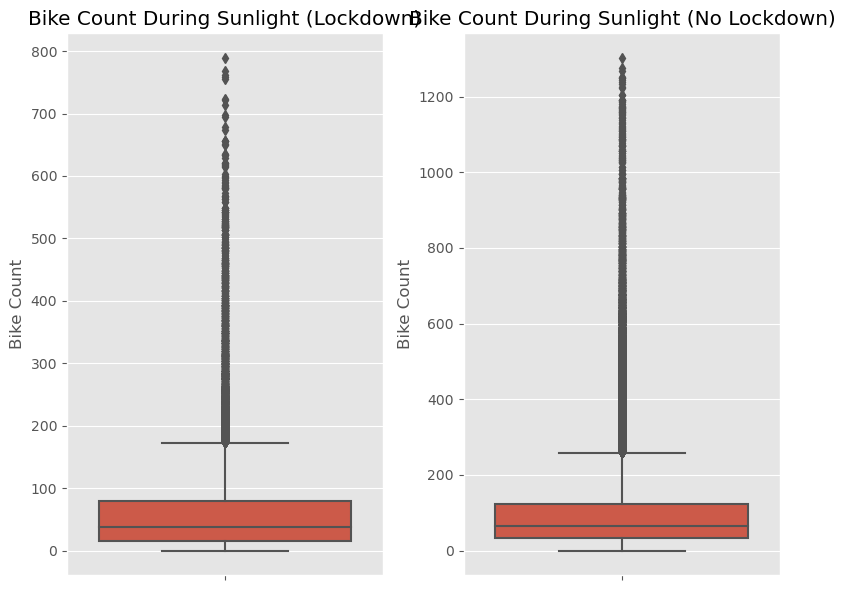

In [17]:
bike_count_lockdown = df[(df['sunlight'] == 1) & (df['is_lockdown'] == 1)]['bike_count']
bike_count_no_lockdown = df[(df['sunlight'] == 1) & (df['is_lockdown'] == 0)]['bike_count']

# Create box plots for bike count during sunlight with and without lockdown
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=bike_count_lockdown)
plt.title('Bike Count During Sunlight (Lockdown)')
plt.ylabel('Bike Count')

plt.subplot(1, 2, 2)
sns.boxplot(y=bike_count_no_lockdown)
plt.title('Bike Count During Sunlight (No Lockdown)')
plt.ylabel('Bike Count')

plt.tight_layout()
plt.show()

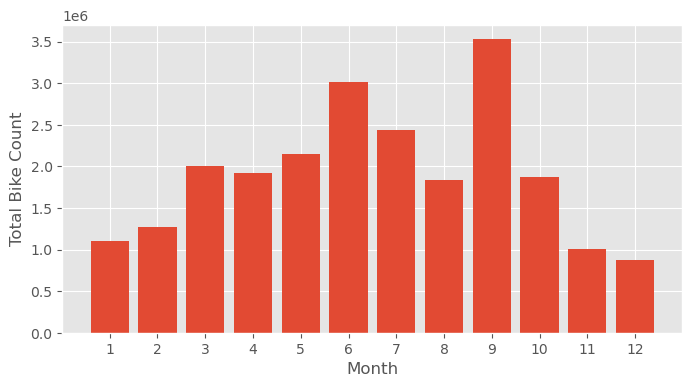

In [49]:
bike_count_sunlight = df[df['sunlight'] == 1]

# Calculate total bike count for each month during sunlight
monthly_counts = bike_count_sunlight.groupby('Month')['bike_count'].sum()

# Create a bar plot for total bike count per month during sunlight
plt.figure(figsize=(8, 4))
plt.bar(monthly_counts.index, monthly_counts.values)
plt.xlabel('Month')
plt.ylabel('Total Bike Count')

plt.xticks(range(1, 13))  # Setting x-ticks to correspond to months
plt.show()


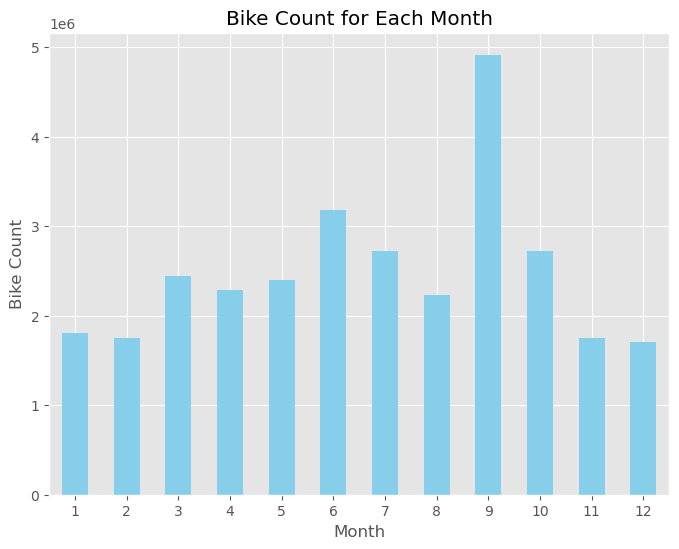

In [22]:
monthly_counts = df.groupby('Month')['bike_count'].sum()

# Plotting the bike count for each month
plt.figure(figsize=(8, 6))
monthly_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Bike Count')
plt.title('Bike Count for Each Month')
plt.xticks(rotation=0)  # Ensure proper rotation of x-axis labels
plt.show()

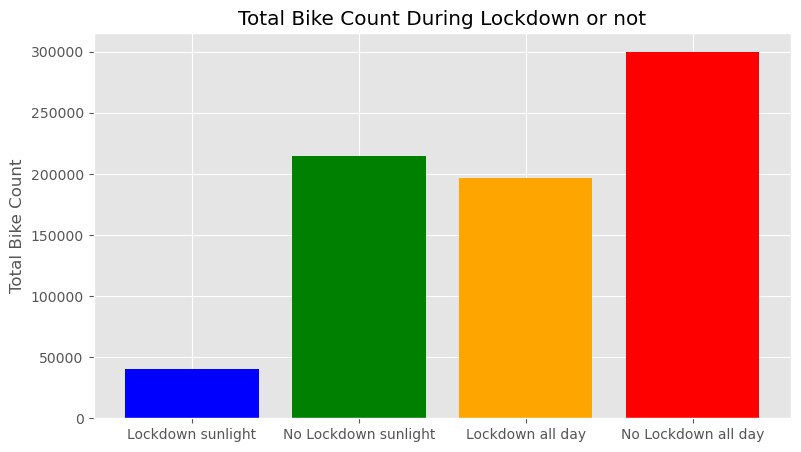

In [27]:
lockdown_sunlight = df[(df['sunlight'] == 1) & (df['is_lockdown'] == 1)].count()['bike_count']
no_lockdown_sunlight = df[(df['sunlight'] == 1) & (df['is_lockdown'] == 0)].count()['bike_count']
lockdown_allday = df[df['is_lockdown'] == 1].count()['bike_count']
no_lockdown_allday = df[df['is_lockdown'] == 0].count()['bike_count']

# Creating lists for categories and their corresponding counts
categories = ['Lockdown sunlight', 'No Lockdown sunlight', 'Lockdown all day', 'No Lockdown all day']
counts = [lockdown_sunlight, no_lockdown_sunlight, lockdown_allday, no_lockdown_allday]

# Creating a bar plot
plt.figure(figsize=(9, 5))
plt.bar(categories, counts, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Total Bike Count')
plt.title('Total Bike Count During Lockdown or not')
plt.show()


In [31]:
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,Day,Weekday,Is_weekend,Hour,sunlight,season,is_holiday,is_lockdown,Hour_sin,Hour_cos
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,1,1,0,2,0,Autumn,0,0,0.519584,0.854419
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,1,1,0,3,0,Autumn,0,0,0.730836,0.682553
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,1,1,0,4,0,Autumn,0,0,0.887885,0.460065
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,1,1,0,15,1,Autumn,0,0,-0.816970,-0.576680
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,1,1,0,18,1,Autumn,0,0,-0.979084,0.203456


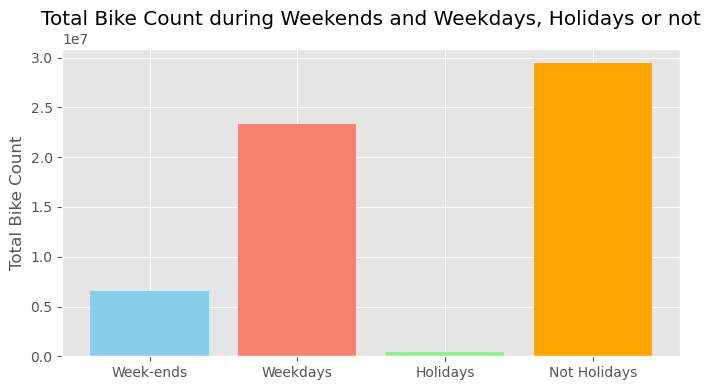

In [37]:
# Filtering the DataFrame for different categories
is_weekend_1 = df[df['Is_weekend'] == 1]['bike_count'].sum()
is_weekend_0 = df[df['Is_weekend'] == 0]['bike_count'].sum()
is_holiday_1 = df[df['is_holiday'] == 1]['bike_count'].sum()
is_holiday_0 = df[df['is_holiday'] == 0]['bike_count'].sum()

# Plotting the totals in a bar chart
plt.figure(figsize=(7, 4))

# Create bar plot
categories = ['Week-ends', 'Weekdays', 'Holidays', 'Not Holidays']
values = [is_weekend_1, is_weekend_0, is_holiday_1, is_holiday_0]
plt.bar(categories, values, color=['skyblue', 'salmon', 'lightgreen', 'orange'])

# Set labels and title
plt.ylabel('Total Bike Count')
plt.title('Total Bike Count during Weekends and Weekdays, Holidays or not')

plt.tight_layout()
plt.show()

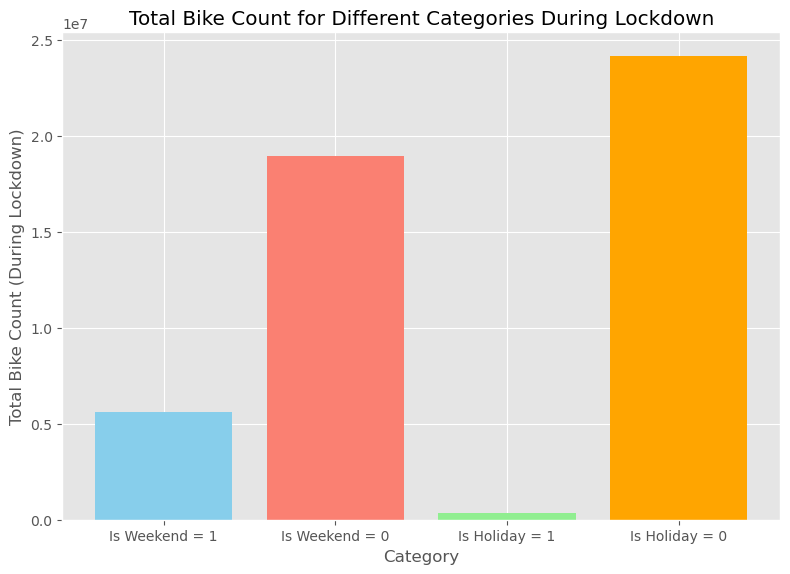

In [35]:
is_weekend_1_lockdown = df[(df['Is_weekend'] == 1) & (df['is_lockdown'] == 0)]['bike_count'].sum()
is_weekend_0_lockdown = df[(df['Is_weekend'] == 0) & (df['is_lockdown'] == 0)]['bike_count'].sum()
is_holiday_1_lockdown = df[(df['is_holiday'] == 1) & (df['is_lockdown'] == 0)]['bike_count'].sum()
is_holiday_0_lockdown = df[(df['is_holiday'] == 0) & (df['is_lockdown'] == 0)]['bike_count'].sum()

# Plotting the totals in a bar chart
plt.figure(figsize=(8, 6))

# Create bar plot
categories = ['Is Weekend = 1', 'Is Weekend = 0', 'Is Holiday = 1', 'Is Holiday = 0']
values_lockdown = [is_weekend_1_lockdown, is_weekend_0_lockdown, is_holiday_1_lockdown, is_holiday_0_lockdown]
plt.bar(categories, values_lockdown, color=['skyblue', 'salmon', 'lightgreen', 'orange'])

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Total Bike Count (During Lockdown)')
plt.title('Total Bike Count for Different Categories During Lockdown')

plt.tight_layout()
plt.show()

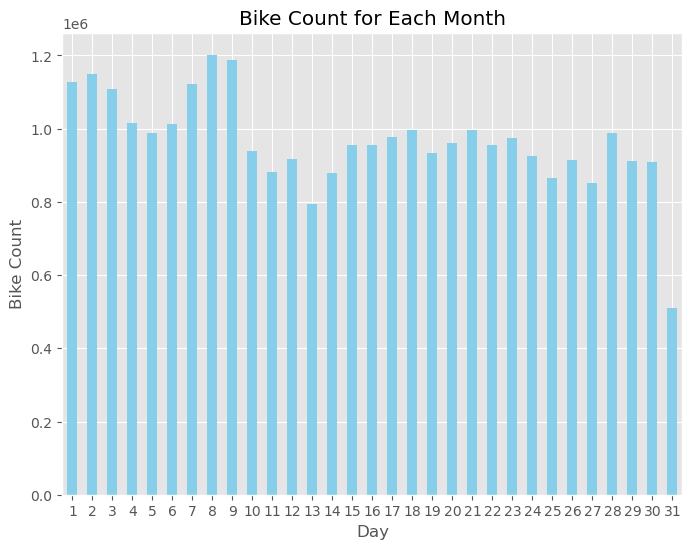

In [48]:
daily_counts = df.groupby('Day')['bike_count'].sum()

# Plotting the bike count for each month
plt.figure(figsize=(8, 6))
daily_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Day')
plt.ylabel('Bike Count')
plt.title('Bike Count for Each Month')
plt.xticks(rotation=0)  # Ensure proper rotation of x-axis labels
plt.show()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[ns]
 6   counter_installation_date  496827 non-null  datetime64[ns]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

In [40]:
num_col = ['site_id', 'bike_count', 'latitude', 'longitude', 'log_bike_count']

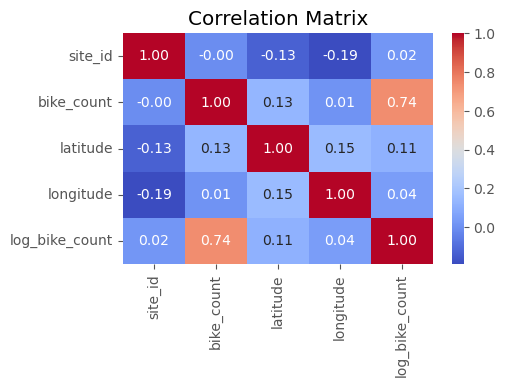

In [44]:
correlation_matrix = df[num_col].corr()

# Set up the matplotlib figure
plt.figure(figsize=(5, 3))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})

# Set the title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

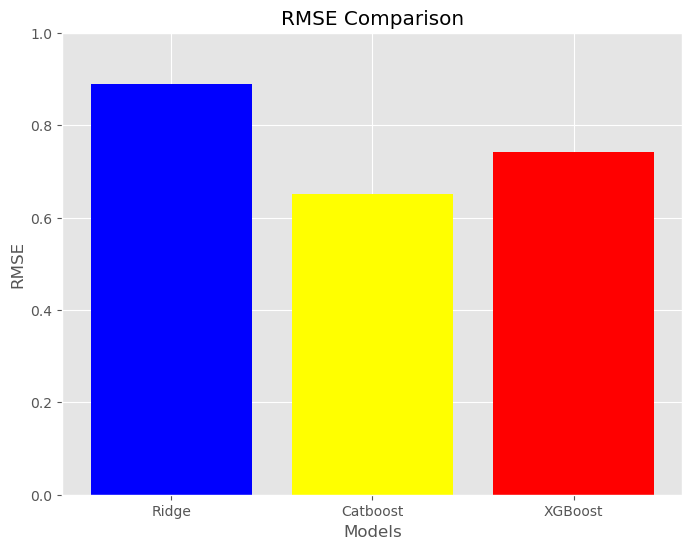

In [58]:
models = ['Ridge', 'Catboost', 'XGBoost']
rmse_values = [0.8884, 0.6501, 0.7412]

plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=['blue', 'yellow', 'red'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.ylim(0, 1)  # Set appropriate y-axis limits
plt.show()

There is one counter (counter_id = 300014702-353245972) that was installed after the beginning of the dataset (counter_installation_date = '2020-11-29 00:00:00'). We can see in the below plot there were thus bike counts before that date). I think we should remove all the entries for this date before it started.

**Actually, there are no entries before the date, so we're good**.

## Creating 'date2' to merge with weather_conditions

In [ ]:
df['date'] = pd.to_datetime(df['date'])

# Create 'date2' column with the desired format 'YYYY-MM-DD'
df['date2'] = df['date'].dt.strftime('%Y-%m-%d')

In [5]:
weather_conditions = pd.read_csv('weather_data_paris_daily.csv')

In [6]:
weather_conditions.drop(axis=1, columns=['name', 'tempmax', 'tempmin', 'temp', 'dew',
                                        'feelslikemax', 'feelslikemax', 'precipprob',
                                        'precipcover', 'snowdepth', 'windgust', 'winddir', 'sealevelpressure',
                                        'solarradiation', 'solarenergy', 'severerisk', 'moonphase',
                                        'conditions', 'stations', 'description','sunrise','sunset',
                                         'snow'], inplace=True)

In [7]:
weather_conditions.head()

,datetime,feelslikemin,feelslike,humidity,precip,preciptype,windspeed,cloudcover,visibility,uvindex,icon
0,2020-09-01,11.5,16.1,63.5,0.000,NaN,13.6,50.2,25.1,6,partly-cloudy-day
1,2020-09-02,11.2,16.8,57.3,0.000,NaN,11.1,50.3,24.1,8,partly-cloudy-day
2,2020-09-03,15.3,21.3,52.2,0.000,NaN,17.2,93.0,25.6,6,cloudy
3,2020-09-04,18.1,23.0,55.4,0.000,NaN,15.8,53.7,25.4,7,partly-cloudy-day
4,2020-09-05,15.4,17.7,65.0,0.016,rain,18.3,88.1,25.0,6,rain


## remove: cloudcover, precip, visibility, is_lockdown_encoded, windspeed, uvindex, Weekday_sin, Weekday_cos, sunlight_encoded, Year, is_holiday_encoded. 

In [ ]:
merged_df = pd.merge(df, weather_conditions, left_on='date2', right_on='datetime', how='left')

In [ ]:
merged_df = merged_df.drop(axis=1, columns=['counter_id', 'counter_name', 'site_name', 'site_id', 'bike_count', 'date',
                                            'counter_installation_date', 'counter_technical_id', 'icon',
                                            'date2', 'datetime', 'feelslikemin', 'Hour', 'Weekday', 'coordinates',
                                            'season', 'preciptype', 'cloudcover', 'precip', 'visibility'
                                            , 'windspeed', 'uvindex', 'Weekday', 'sunlight', 'Year',
                                           'is_holiday'])

In [ ]:
merged_df.nunique()

In [ ]:
numerical_features = ['feelslike', 'humidity','Hour_sin', 'Hour_cos', 'latitude', 'longitude']

categorical_features = ['Year', 'Month', 'Day']

categorical_features_label = ['Is_weekend']

## StandardScaler() for numerical values

In [ ]:
scaler = StandardScaler()

# Fit and transform the selected columns
scaled_columns = scaler.fit_transform(merged_df[numerical_features])

# Create a DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_columns, columns=numerical_features)

# Replace the original columns with the scaled values in the original DataFrame
merged_df[numerical_features] = scaled_df

## One hot encoding

In [ ]:
#columns_to_encode = merged_df[categorical_features_one_hot]

#ohe = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the selected columns
#one_hot_encoded = ohe.fit_transform(columns_to_encode)

#one_hot_df = pd.DataFrame(one_hot_encoded.toarray(), columns=ohe.get_feature_names_out(categorical_features_one_hot))

# Concatenate the one-hot encoded columns with the original DataFrame
#merged_df = pd.concat([merged_df, one_hot_df], axis=1)

# Drop the original categorical columns as they are now one-hot encoded
#merged_df.drop(categorical_features_one_hot, axis=1, inplace=True)

## Label encoding

In [ ]:
label_encoder = LabelEncoder()

# Apply LabelEncoder to the selected columns
for feature in categorical_features_label:
    merged_df[feature + '_encoded'] = label_encoder.fit_transform(merged_df[feature])

# Drop the original categorical columns as they are now label encoded
merged_df.drop(categorical_features_label, axis=1, inplace=True)


## Applying exact same preprocessing to X_test

In [ ]:
X_test = pd.read_parquet('final_test.parquet')

In [ ]:
X_test['date'] = pd.to_datetime(X_test['date'])

# Extracting Year, Month, Day of Month, Weekday, and Hour into separate columns
X_test['Year'] = X_test['date'].dt.year
X_test['Month'] = X_test['date'].dt.month
X_test['Day'] = X_test['date'].dt.day
X_test['Weekday'] = X_test['date'].dt.weekday  # Monday=0, Sunday=6
X_test['Is_weekend'] = X_test['date'].dt.weekday // 5  # 1 if weekend, 0 if weekday
X_test['Hour'] = X_test['date'].dt.hour

# Define the location (Paris, for example)
city = LocationInfo("Paris", "France", "Europe/Paris")
tz = pytz.timezone(city.timezone)

# Function to determine sunlight based on sunrise and sunset times
def is_daytime(date):
    date = date.replace(tzinfo=tz)  # Make the date timezone-aware
    s = sun(city.observer, date=date)
    sunrise = s['sunrise'].astimezone(tz)
    sunset = s['sunset'].astimezone(tz)
    return sunrise < date < sunset

# Apply the function to create a 'sunlight' column
X_test['sunlight'] = X_test['date'].apply(is_daytime).astype(int)


# Function to determine the season based on month
def get_season(month):
    if month in range(3, 6):  # Spring: March - May
        return 'Spring'
    elif month in range(6, 9):  # Summer: June - August
        return 'Summer'
    elif month in range(9, 12):  # Autumn: September - November
        return 'Autumn'
    else:  # Winter: December - February
        return 'Winter'

# Define holidays for a specific country (France in this example)
fr_holidays = holidays.France()

# Function to check if a date is a holiday
def is_holiday(date):
    return date in fr_holidays

# Apply the functions to create 'season' and 'is_holiday' columns
X_test['season'] = X_test['date'].dt.month.apply(get_season)
X_test['is_holiday'] = X_test['date'].apply(is_holiday).astype(int)


# Define the periods of curfew and lockdown
curfew_periods = [
    ('2020-10-17', '2020-10-29', '21:00', '06:00'),
    ('2020-10-30', '2020-12-15', '00:00', '23:59'),
    ('2020-12-15', '2021-05-19', '18:00', '06:00'),
    ('2021-05-19', '2021-06-20', '21:00', '06:00')
]

# Create a function to check if a date is within a curfew period
def is_within_curfew(date):
    for start, end, start_time, end_time in curfew_periods:
        start = pd.to_datetime(start)
        end = pd.to_datetime(end)
        start_time = pd.to_datetime(start_time).time()
        end_time = pd.to_datetime(end_time).time()

        if start <= date <= end:
            if start.time() == end.time():
                return date.time() >= start_time or date.time() <= end_time
            else:
                return start_time <= date.time() <= end_time
    return False

# Apply the function to create 'is_lockdown' column
#X_test['is_lockdown'] = X_test['date'].apply(is_within_curfew).astype(int)

X_test = encode(X_test, 'Hour', 23)
# X_test = encode(X_test, 'Month', 12)
# X_test = encode(X_test, 'Day', 31)
# X_test = encode(X_test, 'Weekday', 6)
# X_test = encode(X_test, 'Is_weekend', 1)
# X_test = encode(X_test, 'sunlight', 1)


# Create 'date2' column with the desired format 'YYYY-MM-DD'
X_test['date2'] = X_test['date'].dt.strftime('%Y-%m-%d')

merged_X_test = pd.merge(X_test, weather_conditions, left_on='date2', right_on='datetime', how='left')

merged_X_test = merged_X_test.drop(axis=1, columns=['counter_id', 'counter_name', 'site_name', 'site_id', 'date',
                                            'counter_installation_date', 'counter_technical_id',
                                            'date2', 'datetime', 'feelslikemin', 'cloudcover', 'precip', 'visibility',
                                            'Hour', 'Weekday', 'coordinates', 'icon', 'season', 'preciptype',
                                              'windspeed', 'uvindex', 'Weekday', 'sunlight', 'Year',
                                                   'is_holiday'])


#Scaling

# Fit and transform the selected columns
scaled_columns = scaler.fit_transform(merged_X_test[numerical_features])

# Create a DataFrame with the scaled data
scaled_X_test = pd.DataFrame(scaled_columns, columns=numerical_features)

# Replace the original columns with the scaled values in the original DataFrame
merged_X_test[numerical_features] = scaled_X_test

#Encoding One Hot 

#columns_to_encode = merged_X_test[categorical_features_one_hot]

#ohe = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the selected columns
#one_hot_encoded = ohe.fit_transform(columns_to_encode)

#one_hot_X_test = pd.DataFrame(one_hot_encoded.toarray(), columns=ohe.get_feature_names_out(categorical_features_one_hot))

# Concatenate the one-hot encoded columns with the original DataFrame
#merged_X_test = pd.concat([merged_X_test, one_hot_X_test], axis=1)

# Drop the original categorical columns as they are now one-hot encoded
#merged_X_test.drop(categorical_features_one_hot, axis=1, inplace=True)

#Encoding Label

# Apply LabelEncoder to the selected columns
for feature in categorical_features_label:
    merged_X_test[feature + '_encoded'] = label_encoder.fit_transform(merged_X_test[feature])

# Drop the original categorical columns as they are now label encoded
merged_X_test.drop(categorical_features_label, axis=1, inplace=True)

In [ ]:
# Assuming 'X_train' is your training set and 'y_train' is the corresponding target
X_train = merged_df.drop('log_bike_count', axis=1)  # Features
y_train = merged_df['log_bike_count']  # Target

# Assuming 'X_test' is your test set
X_test = merged_X_test  # Features

# Initialize XGBoost model
model = XGBRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the training set
y_pred_train = model.predict(X_train)

y_pred_test = model.predict(X_test)

pred_df = pd.DataFrame({'Id': X_test.index, 'log_bike_count': y_pred_test})

pred_df.to_csv('submission.csv', index=False)

# Calculate RMSE on the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Train RMSE: {train_rmse}")

In [ ]:
from xgboost import plot_importance
plot_importance(model)
plt.show()

remove: cloudcover, precip, visibility, is_lockdown_encoded, windspeed, uvindex, Weekday_sin, Weekday_cos, sunlight_encoded, Year, is_holiday_encoded. 

In [ ]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

pred_df = pd.DataFrame({'Id': X_test.index,
                        'log_bike_count': pred})

pred_df.to_csv('submission.csv', index=False)

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'X_train' is your training set and 'y_train' is the corresponding target
X_train = merged_df.drop('log_bike_count', axis=1)  # Features
y_train = merged_df['log_bike_count']  # Target

# Assuming 'X_test' is your test set
X_test = merged_X_test  # Features

# Initialize CatBoost model
model_catboost = CatBoostRegressor()

# Fit the model on the training data
model_catboost.fit(X_train, y_train)

# Predict on the training set
y_pred_train_catboost = model_catboost.predict(X_train)

# Calculate RMSE on the training set
train_rmse_catboost = np.sqrt(mean_squared_error(y_train, y_pred_train_catboost))
print(f"Train RMSE - CatBoost: {train_rmse_catboost}")

y_pred_test = model_catboost.predict(X_test)

pred_df = pd.DataFrame({'Id': X_test.index, 'log_bike_count': y_pred_test})

pred_df.to_csv('submission.csv', index=False)

In [ ]:
bike_counts_by_site = df.groupby('site_id')['bike_count'].sum()

# Plotting
plt.figure(figsize=(10, 6))
bike_counts_by_site.plot(kind='bar')
plt.title('Bike Count by Site ID')
plt.xlabel('Site ID')
plt.ylabel('Bike Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

29,904,750 bikes in total

In [ ]:
df['bike_count'].sum()

In [ ]:
counter_counts = df.groupby('counter_name')['bike_count'].sum().reset_index().sort_values('bike_count', ascending=False)

print(counter_counts.head(10))

In [ ]:
sns.boxplot(x=df['bike_count'])

plt.title('Box Plot of Bike Count')
plt.xlabel('Bike Count')
plt.show()

In [ ]:
ext = pd.read_csv('external_data.csv')

In [ ]:
ext.info()